<a href="https://colab.research.google.com/github/Nimuar/ME53900_IntroductionToScientificMachineLearning/blob/HW6/Homeworks/homework-06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 6

## References

+ Lectures 21-23 (inclusive).


## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

If on Google Colab, install the following packages:

In [1]:
MAKE_BOOK_FIGURES=True
import numpy as np
import scipy.stats as st

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

def set_book_style():
    plt.style.use('seaborn-v0_8-white')
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings
        'font.family': 'serif',  # For academic publishing
        'font.size': 8,  # As requested, 10pt font
        'axes.labelsize': 8,
        'axes.titlesize': 8,
        'xtick.labelsize': 7,  # Slightly smaller for better readability
        'ytick.labelsize': 7,
        'legend.fontsize': 7,

        # Line and marker settings for consistency
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,

        # Layout to prevent clipped labels
        'figure.constrained_layout.use': True,

        # Default DPI (will override when saving)
        'figure.dpi': 600,
        'savefig.dpi': 600,

        # Despine - remove top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,

        # Remove legend frame
        'legend.frameon': False,

        # Additional trim settings
        'figure.autolayout': True,  # Alternative to constrained_layout
        'savefig.bbox': 'tight',    # Trim when saving
        'savefig.pad_inches': 0.1   # Small padding to ensure nothing gets cut off
    })

def set_notebook_style():
    plt.style.use('seaborn-v0_8-white')
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings - using default sizes
        'font.family': 'serif',
        'axes.labelsize': 10,
        'axes.titlesize': 10,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,

        # Line and marker settings
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,

        # Layout settings
        'figure.constrained_layout.use': True,

        # Remove only top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,

        # Remove legend frame
        'legend.frameon': False,

        # Additional settings
        'figure.autolayout': True,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.1
    })

def save_for_book(fig, filename, is_vector=True, **kwargs):
    """
    Save a figure with book-optimized settings.

    Parameters:
    -----------
    fig : matplotlib figure
        The figure to save
    filename : str
        Filename without extension
    is_vector : bool
        If True, saves as vector at 1000 dpi. If False, saves as raster at 600 dpi.
    **kwargs : dict
        Additional kwargs to pass to savefig
    """
    # Set appropriate DPI and format based on figure type
    if is_vector:
        dpi = 1000
        ext = '.pdf'
    else:
        dpi = 600
        ext = '.tif'

    # Save the figure with book settings
    fig.savefig(f"{filename}{ext}", dpi=dpi, **kwargs)

def make_full_width_fig():
    return plt.subplots(figsize=(4.7, 2.9), constrained_layout=True)

def make_half_width_fig():
    return plt.subplots(figsize=(2.35, 1.45), constrained_layout=True)

if MAKE_BOOK_FIGURES:
    set_book_style()
else:
    set_notebook_style()

make_full_width_fig = make_full_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()
make_half_width_fig = make_half_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()

In [2]:
!pip install gpytorch

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

import gpytorch
from gpytorch.kernels import ScaleKernel, RBFKernel

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.

    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

def sample_functions(mean_func, kernel_func, num_samples=10, num_test=100, nugget=1e-3):
    """Sample functions from a Gaussian process.

    Arguments:
        mean_func -- the mean function. It must be a callable that takes a tensor
            of shape (num_test, dim) and returns a tensor of shape (num_test, 1).
        kernel_func -- the covariance function. It must be a callable that takes
            a tensor of shape (num_test, dim) and returns a tensor of shape
            (num_test, num_test).
        num_samples -- the number of samples to take. Defaults to 10.
        num_test -- the number of test points. Defaults to 100.
        nugget -- a small number required for stability. Defaults to 1e-5.
    """
    X = torch.linspace(0, 1, num_test)[:, None]
    m = mean_func(X)
    C = kernel_func.forward(X, X) + nugget * torch.eye(X.shape[0])
    L = torch.linalg.cholesky(C)
    fig, ax = plt.subplots()
    ax.plot(X, m.detach(), label='mean')
    for i in range(num_samples):
        z = torch.randn(X.shape[0], 1)
        f = m[:, None] + L @ z
        ax.plot(X.flatten(), f.detach().flatten(), color=sns.color_palette()[1], linewidth=0.5,
                label='sample' if i == 0 else None
            )
    plt.legend(loc='best', frameon=False)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_ylim(-5, 5)
    sns.despine(trim=True);

class ExactGP(gpytorch.models.ExactGP):
    def __init__(self,
                 train_x,
                 train_y,
                 likelihood=gpytorch.likelihoods.GaussianLikelihood(),
                mean_module=gpytorch.means.ConstantMean(),
                covar_module=ScaleKernel(RBFKernel())
        ):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = mean_module
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def plot_1d_regression(
    x_star,
    model,
    ax=None,
    f_true=None,
    num_samples=10,
    xlabel='$x$',
    ylabel='$y$'
):
    """Plot the posterior predictive.

    Arguments
    x_start  --  The test points on which to evaluate.
    model    --  The trained model.

    Keyword Arguments
    ax          --  An axes object to write on.
    f_true      --  The true function.
    num_samples --  The number of samples.
    xlabel      --  The x-axis label.
    ylabel      --  The y-axis label.
    """
    f_star = model(x_star)
    m_star = f_star.mean
    v_star = f_star.variance
    y_star = model.likelihood(f_star)
    yv_star = y_star.variance

    f_lower = (
        m_star - 2.0 * torch.sqrt(v_star)
    )
    f_upper = (
        m_star + 2.0 * torch.sqrt(v_star)
    )

    y_lower = m_star - 2.0 * torch.sqrt(yv_star)
    y_upper = m_star + 2.0 * torch.sqrt(yv_star)

    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(model.train_inputs[0].flatten().detach(),
            model.train_targets.detach(),
            'k.',
            markersize=1,
            markeredgewidth=2,
            label='Observations'
    )

    ax.plot(
        x_star,
        m_star.detach(),
        lw=2,
        label='Posterior mean',
        color=sns.color_palette()[0]
    )

    ax.fill_between(
        x_star.flatten().detach(),
        f_lower.flatten().detach(),
        f_upper.flatten().detach(),
        alpha=0.5,
        label='Epistemic uncertainty',
        color=sns.color_palette()[0]
    )

    ax.fill_between(
        x_star.detach().flatten(),
        y_lower.detach().flatten(),
        f_lower.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label='Aleatory uncertainty'
    )
    ax.fill_between(
        x_star.detach().flatten(),
        f_upper.detach().flatten(),
        y_upper.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label=None
    )


    if f_true is not None:
        ax.plot(
            x_star,
            f_true(x_star),
            'm-.',
            label='True function'
        )

    if num_samples > 0:
        f_post_samples = f_star.sample(
            sample_shape=torch.Size([10])
        )
        ax.plot(
            x_star.numpy(),
            f_post_samples.T.detach().numpy(),
            color="red",
            lw=0.5
        )
        # This is just to add the legend entry
        ax.plot(
            [],
            [],
            color="red",
            lw=0.5,
            label="Posterior samples"
        )

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    plt.legend(loc='best', frameon=False)
    sns.despine(trim=True)

    return dict(m_star=m_star, v_star=v_star, ax=ax)


def train(model, train_x, train_y, n_iter=10, lr=0.1):
    """Train the model.

    Arguments
    model   --  The model to train.
    train_x --  The training inputs.
    train_y --  The training labels.
    n_iter  --  The number of iterations.
    """
    model.train()
    optimizer = torch.optim.LBFGS(model.parameters(), line_search_fn='strong_wolfe')
    likelihood = model.likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    def closure():
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print(loss)
        return loss
    for i in range(n_iter):
        loss = optimizer.step(closure)
        if (i + 1) % 1 == 0:
            print(f'Iter {i + 1:3d}/{n_iter} - Loss: {loss.item():.3f}')
    model.eval()

## Student details

+ **First Name:** Kevin
+ **Last Name:** Rivera
+ **Email:** river297@purdue.edu

## Problem 1 - Defining priors on function spaces

In this problem, we will explore further how Gaussian processes can be used to define probability measures over function spaces.
To this end, assume that there is a 1D function, call if $f(x)$, which we do not know.
For simplicity, assume that $x$ takes values in $[0,1]$.
We will employ Gaussian process regression to encode our state of knowledge about $f(x)$ and sample some possibilities.
For each of the cases below:
+ Assume that $f\sim \operatorname{GP}(m, k)$ and pick a mean ($m(x)$) and a covariance function $f(x)$ that match the provided information.
+ Write code that samples a few times (up to five) the values of $f(x)$ at 100 equidistant points between 0 and 1.

### Part A - Super smooth function with known length scale

Assume that you hold the following beliefs
+ You know that $f(x)$ has as many derivatives as you want and they are all continuous
+ You don't know if $f(x)$ has a specific trend.
+ You think that $f(x)$ has "wiggles" that are approximatly of size $\Delta x=0.1$.
+ You think that $f(x)$ is between -4 and 4.

**Answer:**

**I am doing this for you so that you have a concrete example of what is requested.**

The mean function should be:

$$
m(x) = 0.
$$

The covariance function should be a squared exponential:

$$
k(x,x') = s^2\exp\left\{-\frac{(x-x')^2}{2\ell^2}\right\},
$$

with variance:

$$
s^2 = k(x,x) = \mathbb{V}[f(x)] = 4,
$$

and lengthscale $\ell = 0.1$.
We chose the variance to be 4.0 so that with (about) 95% probability, the values of $f(x)$ are between -4 and 4.

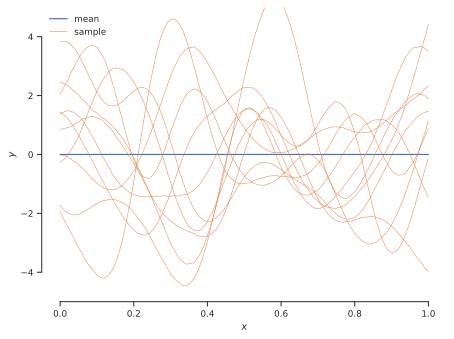

In [4]:
import torch
import gpytorch
from gpytorch.kernels import RBFKernel, ScaleKernel

# Define the covariance function
k = ScaleKernel(RBFKernel())
k.outputscale = 4.0
k.base_kernel.lengthscale = 0.1

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions
sample_functions(mean, k, nugget=1e-4)

### Part B - Super smooth function with known ultra-small length scale

Assume that you hold the following beliefs
+ You know that $f(x)$ has as many derivatives as you want and they are all continuous
+ You don't know if $f(x)$ has a specific trend.
+ You think that $f(x)$ has "wiggles" that are approximatly of size $\Delta x=0.05$.
+ You think that $f(x)$ is between -3 and 3.

**Answer:**

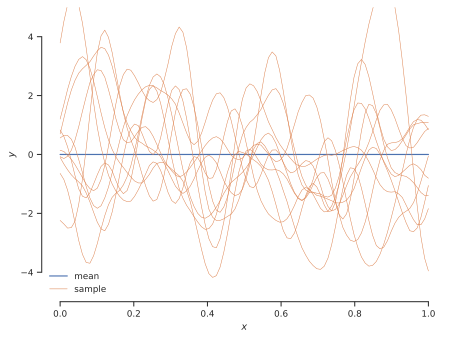

In [5]:
from gpytorch.kernels import RBFKernel, ScaleKernel

# Define the covariance function
k = ScaleKernel(RBFKernel())
k.outputscale = 3.0
k.base_kernel.lengthscale = 0.05

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions
sample_functions(mean, k, nugget=1e-4)

### Part C - Continuous function with known length scale

Assume that you hold the following beliefs
+ You know that $f(x)$ is continuous, nowhere differentiable.
+ You don't know if $f(x)$ has a specific trend.
+ You think that $f(x)$ has "wiggles" that are approximately of size $\Delta x=0.1$.
+ You think that $f(x)$ is between -5 and 5.

Hint: Use ``gpytorch.kernels.MaternKernel`` with $\nu=1/2$.

**Answer:**

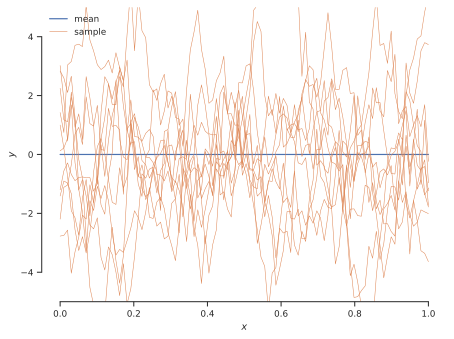

In [6]:
from gpytorch.kernels import MaternKernel, ScaleKernel

# Define the covariance function
k = ScaleKernel(MaternKernel(nu=0.5))
k.outputscale = 5.0
k.base_kernel.lengthscale = 0.1

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions
sample_functions(mean, k, nugget=1e-4)

### Part D - Smooth periodic function with known length scale

Assume that you hold the following beliefs
+ You know that $f(x)$ is smooth.
+ You know that $f(x)$ is periodic with period 0.1.
+ You don't know if $f(x)$ has a specific trend.
+ You think that $f(x)$ has "wiggles" that are approximately of size $\Delta x=0.5$ of the period.
+ You think that $f(x)$ is between -5 and 5.

Hint: Use ``gpytorch.kernels.PeriodicKernel``.

**Answer:**

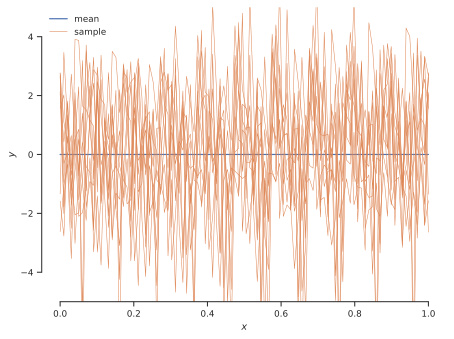

In [7]:
from gpytorch.kernels import PeriodicKernel

# Define the covariance function
k = ScaleKernel(PeriodicKernel())
k.base_kernel.period_length = 0.1
k.outputscale = 5.0
k.base_kernel.lengthscale = 0.05

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions
sample_functions(mean, k, nugget=1e-4)

### Part E - Smooth periodic function with known length scale

Assume that you hold the following beliefs
+ You know that $f(x)$ is smooth.
+ You know that $f(x)$ is periodic with period 0.1.
+ You don't know if $f(x)$ has a specific trend.
+ You think that $f(x)$ has "wiggles" that are approximately of size $\Delta x=0.1$ of the period (**the only thing that is different compared to D**).
+ You think that $f(x)$ is between -5 and 5.

Hint: Use ``gpytorch.kernels.PeriodicKernel``.


**Answer:**

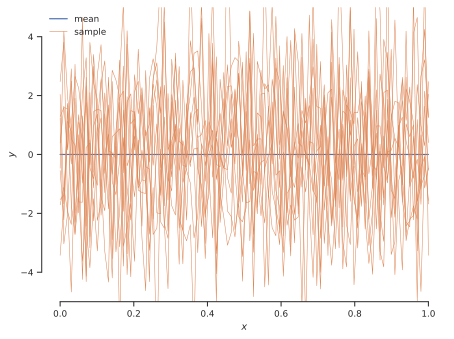

In [8]:
from gpytorch.kernels import PeriodicKernel

# Define the covariance function
k = ScaleKernel(PeriodicKernel())
k.base_kernel.period_length = 0.1
k.outputscale = 5.0
k.base_kernel.lengthscale = 0.01

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions
sample_functions(mean, k, nugget=1e-4)

### Part F - The sum of two functions

Assume that you hold the following beliefs
+ You know that $f(x) = f_1(x) + f_2(x)$, where:
    - $f_1(x)$ is smooth with variance 2 and length scale 0.5
    - $f_2(x)$ is continuous, nowhere differentiable with variance 0.1 and length scale 0.1

Hint: Use must create a new covariance function that is the sum of two other covariances.

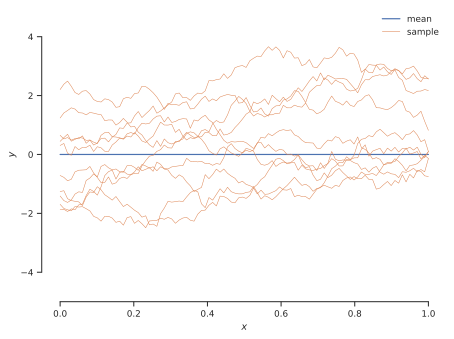

In [9]:
# Define smooth function
ksmooth = ScaleKernel(RBFKernel())
ksmooth.outputscale = 2.0
ksmooth.base_kernel.lengthscale = 0.5

# Define nowhere differentiable function
knowhere = ScaleKernel(MaternKernel(nu=0.5))
knowhere.outputscale = 0.1
knowhere.base_kernel.lengthscale = 0.1

# Define k
k = ksmooth + knowhere

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions
sample_functions(mean, k, nugget=1e-4)

### Part G - The product of two functions

Assume that you hold the following beliefs
+ You know that $f(x) = f_1(x)f_2(x)$, where:
    - $f_1(x)$ is smooth, periodic (period = 0.1), length scale 0.1 (relative to the period), and variance 2.
    - $f_2(x)$ is smooth with length scale 0.5 and variance 1.

Hint: Use must create a new covariance function that is the product of two other covariances.

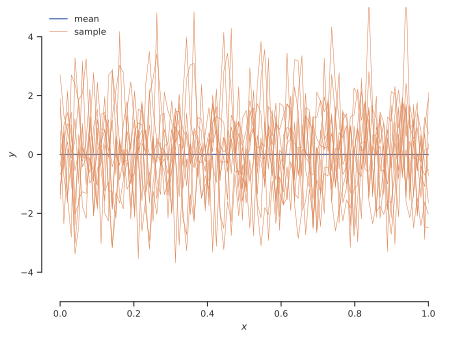

In [10]:
# Define the periodic function
kperiodic = ScaleKernel(PeriodicKernel())
kperiodic.base_kernel.period_length = 0.1
kperiodic.outputscale = 2.0
kperiodic.base_kernel.lengthscale = 0.1

# Define smooth function
ksmooth = ScaleKernel(RBFKernel())
ksmooth.outputscale = 1.0
ksmooth.base_kernel.lengthscale = 0.5

# Define k
k = ksmooth*kperiodic

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions
sample_functions(mean, k, nugget=1e-4)

## Problem 2

The National Oceanic and Atmospheric Administration (NOAA) has been measuring the levels of atmospheric CO2 at the Mauna Loa, Hawaii. The measurements start in March 1958 and go back to January 2016.
The data can be found [here](http://www.esrl.noaa.gov/gmd/ccgg/trends/data.html).
The Python cell below downloads and plots the data set.

In [11]:
url = "https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/lecturebook/data/mauna_loa_co2.txt"
!curl -O $url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46015  100 46015    0     0   123k      0 --:--:-- --:--:-- --:--:--  123k


In [12]:
data = np.loadtxt('mauna_loa_co2.txt')

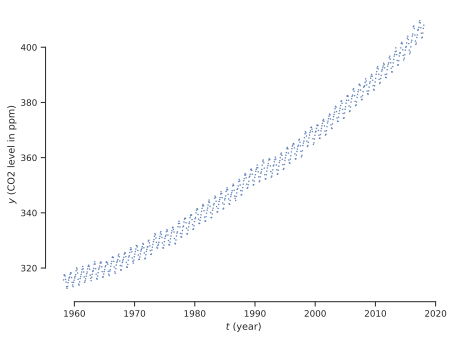

In [13]:
#load data
t = data[:, 2]  #time (in decimal dates)
y = data[:, 4]  #CO2 level (mole fraction in dry air, micromol/mol, abbreviated as ppm)
fig, ax = plt.subplots(1, 1)
ax.plot(t, y, '.', markersize=1)
ax.set_xlabel('$t$ (year)')
ax.set_ylabel('$y$ (CO2 level in ppm)')
sns.despine(trim=True);

Overall, we observe a steady growth of CO2 levels. The wiggles correspond to seasonal changes. Since most of the population inhabits the northern hemisphere, fuel consumption increases during the northern winters, and CO2 emissions follow. Our goal is to study this dataset with Gaussian process regression. Specifically, we would like to predict the evolution of the CO2 levels from Feb 2018 to Feb 2028 and quantify our uncertainty about this prediction.

Working with a scaled version of the inputs and outputs is always a good idea. We are going to scale the times as follows:

$$
t_s = t - t_{\min}.
$$

So, time is still in fractional years, but we start counting at zero instead of 1950.
We scale the $y$'s as:

$$
y_s = \frac{y - y_{\min}}{y_{\max}-y_{\min}}.
$$

This takes all the $y$ between $0$ and $1$.
Here is what the scaled data look like:

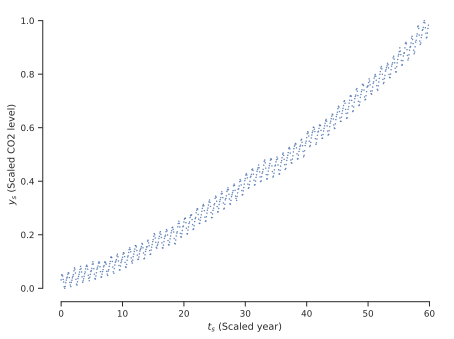

In [14]:
t_s = t - t.min()
y_s = (y - y.min()) / (y.max() - y.min())
fig, ax = plt.subplots(1, 1)
ax.plot(t_s, y_s, '.', markersize=1)
ax.set_xlabel('$t_s$ (Scaled year)')
ax.set_ylabel('$y_s$ (Scaled CO2 level)')
sns.despine(trim=True);

Work with the scaled data in what follows as you develop your model.
Scale back to the original units for your final predictions.

## Part A - Naive approach

Use a zero mean Gaussian process with a squared exponential covariance function to fit the data and make the required prediction (ten years after the last observation).

**Answer:**

**Again, this is done for you so that you have a concrete example of what is requested.**

In [15]:
cov_module = ScaleKernel(RBFKernel())
mean_module = gpytorch.means.ConstantMean()
train_x = torch.from_numpy(t_s).float()
train_y = torch.from_numpy(y_s).float()
naive_model = ExactGP(
    train_x,
    train_y,
    mean_module=mean_module,
    covar_module=cov_module
)
train(naive_model, train_x, train_y)

tensor(0.8545, grad_fn=<NegBackward0>)
tensor(0.7392, grad_fn=<NegBackward0>)
tensor(-0.5164, grad_fn=<NegBackward0>)
tensor(-1.7353, grad_fn=<NegBackward0>)
tensor(-2.1123, grad_fn=<NegBackward0>)
tensor(-2.2573, grad_fn=<NegBackward0>)
tensor(-2.0044, grad_fn=<NegBackward0>)
tensor(-2.2871, grad_fn=<NegBackward0>)
tensor(-2.3023, grad_fn=<NegBackward0>)
tensor(-2.3135, grad_fn=<NegBackward0>)
tensor(-2.3297, grad_fn=<NegBackward0>)
tensor(-2.3330, grad_fn=<NegBackward0>)
tensor(-2.2609, grad_fn=<NegBackward0>)
tensor(-2.3376, grad_fn=<NegBackward0>)
tensor(-2.3396, grad_fn=<NegBackward0>)
tensor(-2.3418, grad_fn=<NegBackward0>)
tensor(-2.3452, grad_fn=<NegBackward0>)
tensor(-2.3467, grad_fn=<NegBackward0>)
tensor(-2.3478, grad_fn=<NegBackward0>)
tensor(-2.3483, grad_fn=<NegBackward0>)
tensor(-2.3508, grad_fn=<NegBackward0>)
tensor(-2.3504, grad_fn=<NegBackward0>)
tensor(-2.3522, grad_fn=<NegBackward0>)
tensor(-2.3530, grad_fn=<NegBackward0>)
tensor(-2.3531, grad_fn=<NegBackward0>)
It

Predict everything:

/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


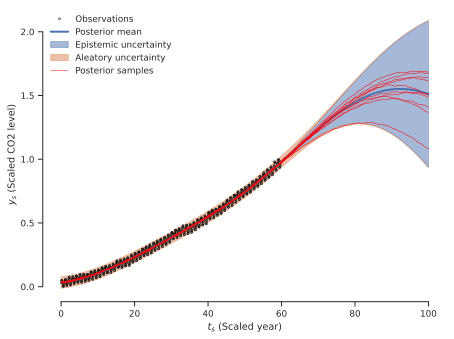

In [16]:
x_star = torch.linspace(0, 100, 100)
plot_1d_regression(model=naive_model, x_star=x_star,
                   xlabel='$t_s$ (Scaled year)', ylabel='$y_s$ (Scaled CO2 level)');

Notice that the squared exponential covariance captures the long terms but fails to capture the seasonal fluctuations. The seasonal fluctuations are treated as noise. This is wrong. You will have to fix this in the next part.

## Part B - Improving the prior covariance

Now, use the ideas of Problem 1 to develop a covariance function that exhibits the following characteristics visible in the data (call $f(x)$ the scaled CO2 level.
+ $f(x)$ is smooth.
+ $f(x)$ has a clear trend with a multi-year length scale.
+ $f(x)$ has seasonal fluctuations with a period of one year.
+ $f(x)$ exhibits small fluctuations within its period.

There is more than one correct answer.

**Answer:**

In [17]:
# Trend with multi year long scale
k_trend = ScaleKernel(RBFKernel())
k_trend.outputscale = 2.0
k_trend.base_kernel.lengthscale = 60

# Periodic Kernel for the years
k_periodic = PeriodicKernel()
k_periodic.period_length = 1.0
k_periodic.lengthscale = 0.5

# RBF Kernel for the variation within a year
k_within = RBFKernel()
k_within.lengthscale = 0.1

k_seasonal = ScaleKernel(k_within * k_periodic)

cov_module = k_trend + k_seasonal
mean_module = gpytorch.means.ConstantMean()
model_2k = ExactGP(
    train_x,
    train_y,
    mean_module=mean_module,
    covar_module=cov_module
)
train(model_2k, train_x, train_y)

tensor(0.5171, grad_fn=<NegBackward0>)
tensor(0.1043, grad_fn=<NegBackward0>)
tensor(-2.2128, grad_fn=<NegBackward0>)
tensor(-1.8731, grad_fn=<NegBackward0>)
tensor(-2.6039, grad_fn=<NegBackward0>)
tensor(-2.7801, grad_fn=<NegBackward0>)
tensor(-1.1470, grad_fn=<NegBackward0>)
tensor(-1.2024, grad_fn=<NegBackward0>)
tensor(-2.8513, grad_fn=<NegBackward0>)
tensor(-1.4678, grad_fn=<NegBackward0>)
tensor(-2.8965, grad_fn=<NegBackward0>)
tensor(-2.8734, grad_fn=<NegBackward0>)
tensor(-2.9451, grad_fn=<NegBackward0>)
tensor(-2.9816, grad_fn=<NegBackward0>)
tensor(-3.0336, grad_fn=<NegBackward0>)
tensor(-3.0724, grad_fn=<NegBackward0>)
tensor(-3.1063, grad_fn=<NegBackward0>)
tensor(-3.1389, grad_fn=<NegBackward0>)
tensor(-1.4776, grad_fn=<NegBackward0>)
tensor(-3.2547, grad_fn=<NegBackward0>)
tensor(-2.6895, grad_fn=<NegBackward0>)
tensor(-3.2270, grad_fn=<NegBackward0>)
tensor(-3.2682, grad_fn=<NegBackward0>)
tensor(-3.2920, grad_fn=<NegBackward0>)
tensor(-3.3129, grad_fn=<NegBackward0>)
It

In [18]:
# Trend with multi year long scale
k_trend = ScaleKernel(RBFKernel())
k_trend.base_kernel.lengthscale = 60

# Periodic Kernel for the years
k_periodic = ScaleKernel(PeriodicKernel())
k_periodic.period_length = 1.0
k_periodic.base_kernel.lengthscale = 0.5

# RBF Kernel for the variation within a year
k_within = ScaleKernel(RBFKernel())
k_within.base_kernel.lengthscale = 0.1

k_seasonal = k_within * k_periodic

cov_module = k_trend + k_seasonal
mean_module = gpytorch.means.ConstantMean()
model_3k = ExactGP(
    train_x,
    train_y,
    mean_module=mean_module,
    covar_module=cov_module
)
train(model_3k, train_x, train_y)

tensor(0.4559, grad_fn=<NegBackward0>)
tensor(0.1502, grad_fn=<NegBackward0>)
tensor(-1.7514, grad_fn=<NegBackward0>)
tensor(-2.7472, grad_fn=<NegBackward0>)
tensor(-1.1846, grad_fn=<NegBackward0>)
tensor(-2.8483, grad_fn=<NegBackward0>)
tensor(-2.9318, grad_fn=<NegBackward0>)
tensor(-2.9498, grad_fn=<NegBackward0>)
tensor(-2.9566, grad_fn=<NegBackward0>)
tensor(-2.9683, grad_fn=<NegBackward0>)
tensor(-2.9706, grad_fn=<NegBackward0>)
tensor(-2.9716, grad_fn=<NegBackward0>)
tensor(-2.9729, grad_fn=<NegBackward0>)
tensor(-2.9175, grad_fn=<NegBackward0>)
tensor(-2.9745, grad_fn=<NegBackward0>)
tensor(-2.9744, grad_fn=<NegBackward0>)
tensor(-2.9755, grad_fn=<NegBackward0>)
tensor(-2.9759, grad_fn=<NegBackward0>)
tensor(-2.9765, grad_fn=<NegBackward0>)
tensor(-2.9775, grad_fn=<NegBackward0>)
tensor(-2.9776, grad_fn=<NegBackward0>)
tensor(-2.9779, grad_fn=<NegBackward0>)
tensor(-2.9779, grad_fn=<NegBackward0>)
tensor(-2.9778, grad_fn=<NegBackward0>)
tensor(-2.9773, grad_fn=<NegBackward0>)
te

Plot using the following block:

/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


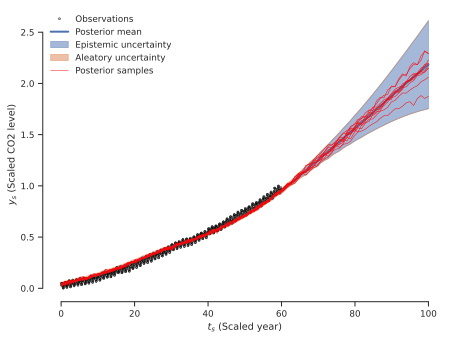

In [19]:
x_star = torch.linspace(0, 100, 100)
plot_1d_regression(model=model_2k, x_star=x_star,
                   xlabel='$t_s$ (Scaled year)', ylabel='$y_s$ (Scaled CO2 level)');

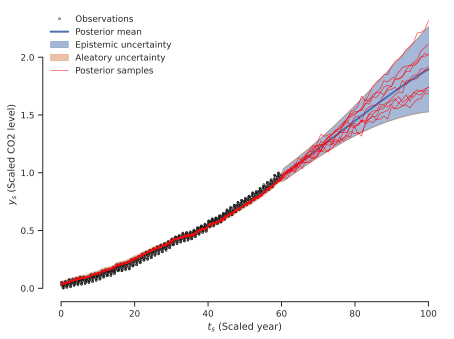

In [20]:
x_star = torch.linspace(0, 100, 100)
plot_1d_regression(model=model_3k, x_star=x_star,
                   xlabel='$t_s$ (Scaled year)', ylabel='$y_s$ (Scaled CO2 level)');

## Part C - Predicting the future

How does your model predict the future? Why is it better than the naive model?

**Answer:**
The Naive model does not take into account details such as noise or seasonal variation. Therefore that complexity is left out when calculating posterior probabilities and making predictions. My model takes the trend and seasonal variation into account and uses it to make the predictions. Making the predictions more accurate and realistic.
<br><br>

## Part D - Bayesian information criterion

As we have seen in earlier lectures, the Bayesian informationc criterion (BIC), see [this](https://en.wikipedia.org/wiki/Bayesian_information_criterion), can bse used to compare two models.
The criterion says that one should:
+ fit the models with maximum likelihood,
+ and compute the quantity:

$$
\text{BIC} = d\ln(n) - 2\ln(\hat{L}),
$$

where $d$ is the number of model parameters, and $\hat{L}$ the maximum likelihood.
+ pick the model with the smallest BIC.

Use BIC to show that the model you constructed in Part C is indeed better than the naïve model of Part A.

**Answer:**

In [21]:
# Hint: You can find the parameters of a model like this
list(naive_model.hyperparameters())

[Parameter containing:
 tensor([-20.9033], requires_grad=True),
 Parameter containing:
 tensor(0.5107, requires_grad=True),
 Parameter containing:
 tensor(-0.7554, requires_grad=True),
 Parameter containing:
 tensor([[34.6343]], requires_grad=True)]

In [22]:
m = sum(p.numel() for p in naive_model.hyperparameters())
print(f'The m for Naive model: {m}')

The m for Naive model: 4


In [23]:
# Hint: You can find the (marginal) log likelihood of a model like this
mll = gpytorch.mlls.ExactMarginalLogLikelihood(naive_model.likelihood, naive_model)
log_like = mll(naive_model(train_x), train_y)
print(f'Marginal Log Likelyhood for Naive Model: {log_like.item()}')

Marginal Log Likelyhood for Naive Model: 1.2222204208374023


/usr/local/lib/python3.11/dist-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [24]:
# Hint: The BIC is
bic_naive = -2 * log_like + m * np.log(train_x.shape[0])
print(f'BIC for Naive Model: {bic_naive.item()}')

BIC for Naive Model: 23.86700439453125


In [25]:
# Finding our model's hyperparams

model_2k.hyperparameters()
model_3k.hyperparameters()

m_2k = sum(p.numel() for p in model_2k.hyperparameters())
m_3k = sum(p.numel() for p in model_3k.hyperparameters())
print(f'The m for the model with 2 Kernels: {m_2k}')
print(f'The m for the model with 3 Kernels: {m_3k}')

The m for the model with 2 Kernels: 8
The m for the model with 3 Kernels: 9


In [26]:
# Finding the (marginal) log likelihood of our model
mll_2k = gpytorch.mlls.ExactMarginalLogLikelihood(model_2k.likelihood, model_2k)
log_like_2k = mll_2k(model_2k(train_x), train_y)

mll_3k = gpytorch.mlls.ExactMarginalLogLikelihood(model_3k.likelihood, model_3k)
log_like_3k = mll_3k(model_3k(train_x), train_y)

print(f'Marginal Log Likelyhood for 2k Model: {log_like_2k.item()}')
print(f'Marginal Log Likelyhood for 3k Model: {log_like_3k.item()}')

Marginal Log Likelyhood for 2k Model: 3.5345728397369385
Marginal Log Likelyhood for 3k Model: 3.5242257118225098


In [27]:
# The BIC is
bic_2k = -2 * log_like_2k + m_2k * np.log(train_x.shape[0])
bic_3k = -2 * log_like_3k + m_3k * np.log(train_x.shape[0])

print(f'BIC for 2k Model: {bic_2k.item()}')
print(f'BIC for 3k Model: {bic_3k.item()}')

BIC for 2k Model: 45.55374526977539
BIC for 3k Model: 52.15230178833008


In [28]:
if bic_2k < bic_3k:
    bic_model = bic_2k
    print("We use the 2k model since it is better than the 3k model")
else:
    bic_model = bic_3k
    print("We use the 3k model since it is better than the 2k model")

We use the 2k model since it is better than the 3k model


In [29]:
if bic_model < bic_naive:
    print("Our model is better than the naive model")
else:
    print("Our model is not better than the naive model")

Our model is not better than the naive model


I implemented and compared two versions of the improved model: one using two ScaleKernels (2k), and another using three ScaleKernels (3k).

While the 3k version offered slightly better uncertainty estimates, its BIC was higher due to the added complexity. The 2k version maintained strong predictive performance and a realistic extrapolation while having a better BIC.

Therefore, for this problem, I would choose the 2k model.

When compared to the naive model, 2k model has a higher BIC but provides more accurate predictions due to it taking into account the noise and seasonal variation. Therefore, though the naive model has a lower BIC, I would choose the 2k model due to its better predictions.

## Problem 3 - Bayesian Global Optimization

As a toy example, we will apply Bayesian Optimization to some synthetic data. We will study the classic [Forrester function](https://www.sfu.ca/~ssurjano/forretal08.html)

$$
f(x) = (6x - 2)^2\sin(12x - 4)
$$

on the domain $[0,1]$. We will also $\textit{standardize}$ the output of the function, such that it has a mean of $0$ and a standard deviation of $1$. This is a good habit to get into when working with Gaussian processes. We will stick to a zero mean prior, so ensuring that the data has a mean of zero aligns with this.

The mean and standard deviation of this function on $[0,1]$ are known:
$$
\begin{aligned}
 \mu &= 0.45321 \\
 \mathrm{std} &= 4.4248
\end{aligned}
$$

The goal is to find the minimum of this objective function.

### Part A - Visualize the function and generate some data

Let's visualize the ground truth objective function and our synthetic data. First, code the **standardized** Forrester function in a way that allows for **minimization** using our Bayesian global **maximization** algorithms from the lecture book.

(Hint: to minimize a function, you can maximize the negative of that function)

In [30]:
mu = 0.45321
std = 4.4248

def Forrester(x):
    """ground truth function to optimize"""

    f = ((6*x - 2) ** 2) * (np.sin(12*x - 4))

    return (f - mu) / std

In [31]:
# making synthetic data from your function

np.random.seed(539)

sigma_noise = 0.025

# noisy version of the above function
F_noisy = lambda x: (
    Forrester(x)
    + sigma_noise * np.random.randn(x.shape[0])
)

# generate synthetic data
n_init = 5
X = np.random.rand(n_init)
Y = F_noisy(X)

train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()

Plot it on $[0,1]$ and make sure to include the data points

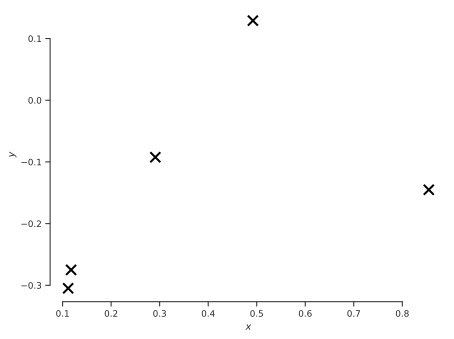

In [32]:
xs = np.linspace(0, 1, 100)
plt.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
plt.xlabel('$x$')
plt.ylabel('$y$')
sns.despine(trim=True);

### Part B - Set up the Gaussian process model

Set up the Gaussian process model.

Specifically, use this:

1. A Matern covariance kernel
2. Zero mean function
3. A Gaussian likelihood model
4. Set the likelihood noise to the ground truth noise (since we assume it is known)

In [33]:
model = ExactGP(train_x, train_y)

model.covar_module = ScaleKernel(MaternKernel(nu=2.5))
model.mean_module = gpytorch.means.ZeroMean()
model.likelihood.noise = sigma_noise

### Now train the model on the data points to optimize the rest of the hyperparameters

Here is the training function you should be using:

In [34]:
def train(model, train_x, train_y, n_iter=10, lr=0.1):
    """Train the model.

    Arguments
    model   --  The model to train.
    train_x --  The training inputs.
    train_y --  The training labels.
    n_iter  --  The number of iterations.
    """
    model.train()
    optimizer = torch.optim.LBFGS(model.parameters(), line_search_fn='strong_wolfe')
    likelihood = model.likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    def closure():
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        return loss
    for i in range(n_iter):
        loss = optimizer.step(closure)
        if (i + 1) % 1 == 0:
            print(f'Iter {i + 1:3d}/{n_iter} - Loss: {loss.item():.3f}')
    model.eval()

In [35]:
train(model, train_x, train_y)

Iter   1/10 - Loss: 0.124
Iter   2/10 - Loss: -0.692
Iter   3/10 - Loss: -0.692
Iter   4/10 - Loss: -0.692
Iter   5/10 - Loss: -0.692
Iter   6/10 - Loss: -0.692
Iter   7/10 - Loss: -0.692
Iter   8/10 - Loss: -0.692
Iter   9/10 - Loss: -0.692
Iter  10/10 - Loss: -0.692


### Plot the trained model along with some sample paths

/tmp/ipython-input-30-3878560087.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  f = ((6*x - 2) ** 2) * (np.sin(12*x - 4))


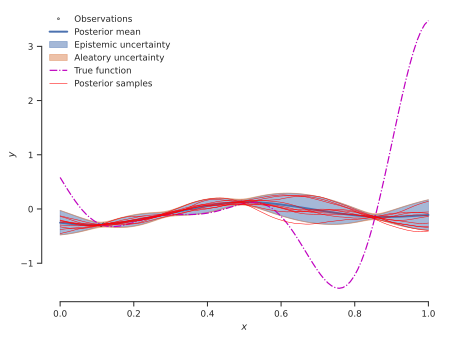

In [36]:
plot_1d_regression(
    torch.from_numpy(xs).float(),
    model,
    f_true=Forrester
);

### Plot the uncertainty about the optimization problem for the initial Gaussian process surrogate

In [37]:
def plot_max_and_argmax(gpr, X_design, n_samples=1000):
    """Plot histograms of the max and argmax of the function represented by the model gpr.

    Arguments
    gpr      -- A trained Gaussian process object.
    X_design -- A set of points to evaluate the response on.

    Keyword Arguments
    n_samples -- The number of samples to take to make the histograms.
    """
    f_star = gpr(X_design)
    f_samples = f_star.sample(sample_shape=torch.Size([n_samples])).numpy()
    max_f_samples = np.max(f_samples, axis=1)
    x_star_samples = X_design.numpy()[np.argmax(f_samples, axis=1)]

    fig, ax = plt.subplots(1,2)
    ax[0].hist(max_f_samples, density=True, alpha=0.25)
    ax[0].set_xlabel('$f^*$')
    ax[0].set_ylabel(r'$p(f^*|\mathcal{D}_n)$')

    ax[1].hist(x_star_samples, density=True, alpha=0.25)
    ax[1].set_xlabel('$x^*$')
    ax[1].set_ylabel(r'$p(x^*|\mathcal{D}_n)$')

    plt.tight_layout()
    sns.despine(trim=True)

    return fig, ax


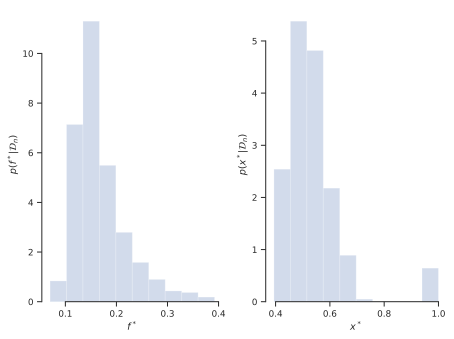

In [38]:
x = torch.linspace(0, 1, 100)
plot_max_and_argmax(model, x);

## Part C - Expected improvement with noise

Solve the optimization problem by applying the expected improvement with noise algorithm

In [39]:
def plot_1d_regression(
    x_star,
    model,
    ax=None,
    f_true=None,
    num_samples=10
):
    """Plot the posterior predictive.

    Arguments
    x_start  --  The test points on which to evaluate.
    model    --  The trained model.

    Keyword Arguments
    ax          --  An axes object to write on.
    f_true      --  The true function.
    num_samples --  The number of samples.
    """
    f_star = model(x_star)
    m_star = f_star.mean
    v_star = f_star.variance
    y_star = model.likelihood(f_star)
    yv_star = y_star.variance

    f_lower = (
        m_star - 2.0 * torch.sqrt(v_star)
    )
    f_upper = (
        m_star + 2.0 * torch.sqrt(v_star)
    )

    y_lower = m_star - 2.0 * torch.sqrt(yv_star)
    y_upper = m_star + 2.0 * torch.sqrt(yv_star)

    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(model.train_inputs[0].flatten().detach(),
            model.train_targets.detach(),
            'kx',
            markersize=10,
            markeredgewidth=2,
            label='Observations'
    )

    ax.plot(
        x_star,
        m_star.detach(),
        lw=2,
        label='$m_n(x)$',
        color=sns.color_palette()[0]
    )

    ax.fill_between(
        x_star.flatten().detach(),
        f_lower.flatten().detach(),
        f_upper.flatten().detach(),
        alpha=0.5,
        label='$f(\mathbf{x}^*)$ 95% pred.',
        color=sns.color_palette()[0]
    )

    ax.fill_between(
        x_star.detach().flatten(),
        y_lower.detach().flatten(),
        f_lower.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label='$y^*$ 95% pred.'
    )
    ax.fill_between(
        x_star.detach().flatten(),
        f_upper.detach().flatten(),
        y_upper.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label=None
    )


    if f_true is not None:
        ax.plot(
            x_star,
            f_true(x_star),
            'm-.',
            label='True function'
        )

    if num_samples > 0:
        f_post_samples = f_star.sample(
            sample_shape=torch.Size([10])
        )
        ax.plot(
            x_star.numpy(),
            f_post_samples.T.detach().numpy(),
            color="red",
            lw=0.5
        )
        # This is just to add the legend entry
        ax.plot(
            [],
            [],
            color="red",
            lw=0.5,
            label="Posterior samples"
        )

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    plt.legend(loc='best', frameon=False)
    sns.despine(trim=True)

    return m_star, v_star

def plot_iaf(
    x_star,
    gpr,
    alpha,
    alpha_params={},
    ax=None,
    f_true=None,
    iaf_label="Information Acquisition Function"
):
    """Plot the information acquisition function.

    Arguments
    x_star       -- A set of points to plot on.
    gpr          -- A rained Gaussian process regression
                    object.
    alpha        -- The information acquisition function.
                    This assumed to be a function of the
                    posterior mean and standard deviation.

    Keyword Arguments
    ax           -- An axes object to plot on.
    f_true       -- The true function - if available.
    alpha_params -- Extra parameters to the information
                    acquisition function.
    ax           -- An axes object to plot on.
    f_true       -- The true function - if available.
    iaf_label    -- The label for the information acquisition
                    function. Default is "Information Acquisition".

    The evaluation of the information acquisition function
    is as follows:

        af_values = alpha(mu, sigma, y_max, **alpha_params)

    """
    if ax is None:
        fig, ax = plt.subplots()

    ax.set_title(
        ", ".join(
            f"{n}={k:.2f}"
            for n, k in alpha_params.items()
            )
    )

    m, v = plot_1d_regression(
        x_star,
        gpr,
        ax=ax,
        f_true=f_true,
        num_samples=0
    )

    sigma = torch.sqrt(v)
    af_values = alpha(m, sigma, gpr.train_targets.numpy().max(), **alpha_params)
    next_id = torch.argmax(af_values)
    next_x = x_star[next_id]
    af_max = af_values[next_id]

    ax2 = ax.twinx()
    ax2.plot(x_star, af_values.detach(), color=sns.color_palette()[1])
    ax2.set_ylabel(
        iaf_label,
        color=sns.color_palette()[1]
    )
    plt.setp(
        ax2.get_yticklabels(),
        color=sns.color_palette()[1]
    )
    ax2.plot(
        next_x * np.ones(100),
        torch.linspace(0, af_max.item(), 100),
        color=sns.color_palette()[1],
        linewidth=1
    )

def ei(m, sigma, ymax):
    """Return the expected improvement.

    Arguments
    m     -- The predictive mean at the test points.
    sigma -- The predictive standard deviation at
             the test points.
    ymin  -- The minimum observed value (so far).
    """
    diff = m - ymax
    u = diff / sigma
    ei = ( diff * torch.distributions.Normal(0, 1).cdf(u) +
          sigma * torch.distributions.Normal(0, 1).log_prob(u).exp()
    )
    ei[sigma <= 0.] = 0.
    return ei

def maximize(
    f,
    model,
    X_design,
    alpha,
    alpha_params={},
    max_it=10,
    optimize=False,
    plot=False,
    **kwargs
):
    """Optimize a function using a limited number of evaluations.

    Arguments
    f            -- The function to optimize.
    gpr          -- A Gaussian process model to use for representing
                    our state of knowledge.
    X_design     -- The set of candidate points for identifying the
                    maximum.
    alpha        -- The information acquisition function.
                    This assumed to be a function of the
                    posterior mean and standard deviation.

    Keyword Arguments
    alpha_params -- Extra parameters to the information
                    acquisition function.
    max_it       -- The maximum number of iterations.
    optimize     -- Whether or not to optimize the hyper-parameters.
    plot         -- Determines how often to plot. Make it one
                    to plot at each iteration. Make it max_it
                    to plot at the last iteration.

    The rest of the keyword arguments are passed to plot_iaf().
    """
    af_all = []
    for count in range(max_it):
        # Predict
        f_design = model(X_design)
        m = f_design.mean
        sigma2 = f_design.variance
        sigma = torch.sqrt(sigma2)

        # Evaluate information acquisition function
        y_train = model.train_targets.numpy()
        af_values = alpha(
            m,
            sigma,
            y_train.max(),
            **alpha_params
        )

        # Find best point to include
        i = torch.argmax(af_values)
        af_all.append(af_values[i])

        new_x = X_design[i:(i+1)].float()
        new_y = f(new_x)
        train_x = torch.cat([model.train_inputs[0], new_x[:, None]])
        train_y = torch.cat([model.train_targets, new_y])
        model.set_train_data(train_x, train_y, strict=False)

        if optimize:
            train(model, train_x, train_y, n_iter=100, lr=0.1)
        else:
            model.train()
            model.eval()

        # Plot if required
        if count % plot == 0:
            if "ax" in kwargs:
                ax = kwargs[ax]
            else:
                fig, ax = plt.subplots()
            plot_iaf(
                X_design,
                model,
                alpha,
                alpha_params=alpha_params,
                f_true=f,
                ax=ax,
                **kwargs
            )
            ax.set_title(
                f"N={count}, " + ax.get_title()
            )
    return af_all

### run the algorithm

/tmp/ipython-input-30-3878560087.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  f = ((6*x - 2) ** 2) * (np.sin(12*x - 4))
/tmp/ipython-input-39-1116358585.py:186: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  next_x * np.ones(100),


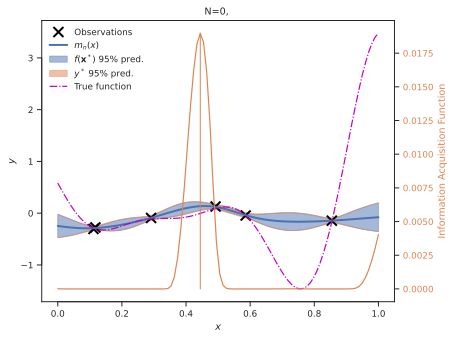

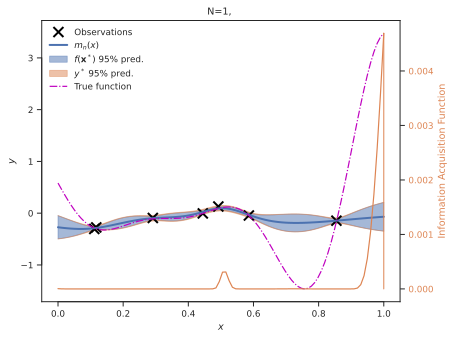

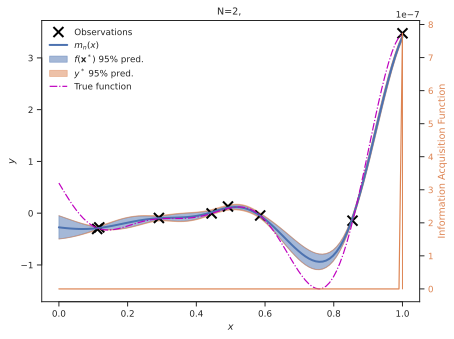

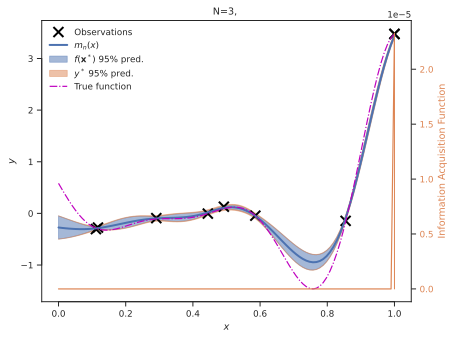

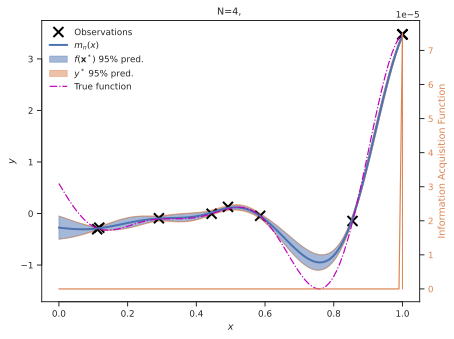

In [40]:
af_all = maximize(
    Forrester,
    model,
    x,
    ei,
    max_it=5,
    plot=1
)

### How many iterations does the algorithm take to converge? That is, how quickly does it identify the critical point?

The algorithm takes 3 iterations to converge.

### Quantify the uncertainty about the solution to the optimization problem with the trained Gaussian process


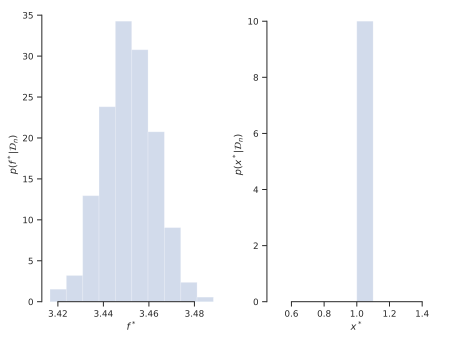

In [41]:
plot_max_and_argmax(model, x);

## Part D - Testing your intuition

In a real-world scenario, you may not be able to keep running experiments until the optimization problem has obviously converged due to time, budget considerations, etc. Imagine yourself in a situation where you are deciding whether or not to query the blackbox function an additional time.

Describe (in words) how you could make this decision using the principles you've learned in this course.

I would use the expected improvement to determine whether an additional query is needed. If the expected improvement is very small across the entire input, this tells us that the model has found a good optimum and further iterations will not improve the result. I would also look at the uncertainty. If the model has low variance and predicted improvement is low, I would stop. But if there's still high uncertainty near the high EI values, I would do another query.